In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

In [39]:
YEAR = 2023
MONTH = 6

INPUT_DATA_DIR = 'output/'
OUTPUT_DATA_DIR = 'output/'

In [40]:
data = pd.read_csv(f'{INPUT_DATA_DIR}/{YEAR}_{MONTH}.csv')
data.head(2)

,Date,Description,Amount,AutoCategory,AccHolder,BankName,AccType
0,2023-06-01,KROGER 605,-23.8,Groceries,joint,chase,credit
1,2023-06-01,DD DOORDASH MARCOSPIZ,-15.9,Food & Drink,joint,chase,credit


In [41]:
def write_to_excel(data, filename):
    writer = pd.ExcelWriter(f"{INPUT_DATA_DIR}/{filename}.xlsx")

    data.to_excel(writer, 
                index=False,
                freeze_panes=(1,0),
                sheet_name='Sheet_1',
                engine='xlsxwriter')

    workbook  = writer.book
    worksheet = writer.sheets['Sheet_1']
    wrap_format = workbook.add_format({'text_wrap': True})
    worksheet.set_column('A:A', 12)
    worksheet.set_column('B:B', 30, wrap_format)
    worksheet.set_column('D:D', 12, wrap_format)
    worksheet.set_column('H:H', 12)
    writer.save()

In [42]:
def check_string(text, pattern):
    if isinstance(pattern, str):
        return pattern in text
    elif isinstance(pattern, list):
        return any(check_string(text, pat) for pat in pattern)
    else:
        return False

In [43]:
category_info = pd.read_csv(f'utils/category.csv')
category_info.head(5)

,Keyword,Category,Subcategory
0,patel brothers,groceries,patel brothers
1,kroger,groceries,kroger
2,instacart,groceries,online
3,market@work,groceries,snacks
4,univ of michigan umich epay,house,rent


In [44]:
def find_category(row):
    desc = row['Description'].lower()
    desc = ' '.join(desc.strip().split()) # removing extra whitespace
    # categ = row['AutoCategory'].lower()

    for index, row in category_info.iterrows():
        if row['Keyword'] in desc:
            return row[['Category', 'Subcategory']]
    
    return pd.Series({'Category': 'others', 'Subcategory': 'others'})

In [45]:
data[['Category', 'Subcategory']] = data.apply(
    find_category, axis=1, result_type='reduce')

In [46]:
empty_cats = (data['Category'].values == 'others').sum()
total_records = len(data)
print(f"Empty categories: {100*empty_cats/total_records :.2f} %")

Empty categories: 25.71 %


In [47]:
data.to_csv(f'{OUTPUT_DATA_DIR}{YEAR}_{MONTH}_notes.csv', index=False)
write_to_excel(data, f'{YEAR}_{MONTH}_notes')

In [48]:
def plot_pie(df):
    display(df.to_frame().T)
    colors = sns.color_palette('pastel', n_colors = len(df))

    plt.pie(np.abs(df.values.squeeze()),
            labels = df.index + ": $" + np.abs(df.values.squeeze()).astype(int).astype(str),
            colors = colors,
            startangle = 90)
    plt.show()

In [52]:
all_expenses = data.pivot_table(values='Amount', index='Category', aggfunc='sum').squeeze().sort_values(ascending=False)

Category,subscription,shopping,mobile,groceries,restaurant,travel
Amount,-80.51,-117.05,-149.21,-231.26,-239.51,-1589.41


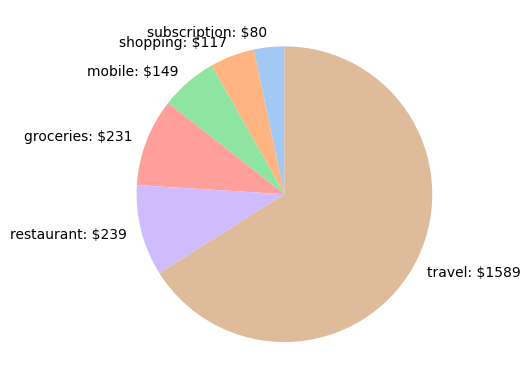

In [53]:
all_expenses = data.pivot_table(values='Amount', index='Category', aggfunc='sum').squeeze().sort_values(ascending=False)
relevant_expenses = all_expenses.drop(index=['salary', 'others', 'transfer']) # , 'house'
plot_pie(relevant_expenses)

Subcategory,online,om market,snacks,patel brothers,kroger
Amount,0.0,-8.99,-18.32,-32.13,-171.82


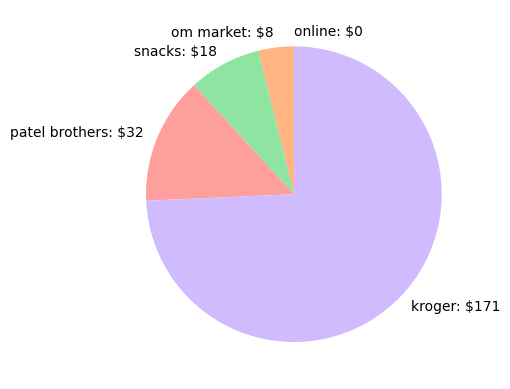

In [58]:
groceries_expenses = data.query("Category == 'groceries'").pivot_table(values='Amount', index='Subcategory', aggfunc='sum').squeeze().sort_values(ascending=False)
plot_pie(groceries_expenses)

Subcategory,bus,cab,gas,flight,stay
Amount,-6.0,-17.85,-130.03,-531.92,-903.61


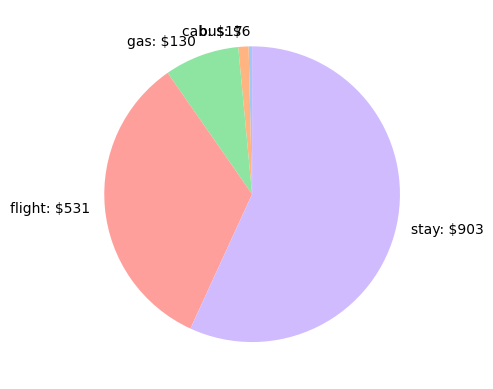

In [60]:
travel_expenses = data.query("Category == 'travel'").pivot_table(values='Amount', index='Subcategory', aggfunc='sum').squeeze().sort_values(ascending=False)
plot_pie(travel_expenses)